**Rio de Janeiro, 22 de Maio de 2016**

Aluno: **Carlos Mattoso **_[ **1210553** ]_

Disciplina: **INF1608 - Análise Numérica**

# Lista 4

## Método de Newton

### Descrição
Apresenta-se o pseudo-código do _método de Newton_ posteriormente implementado em _Python_. Este algoritmo foi extraído do _slide_ `12-8` de http://www.seas.ucla.edu/~vandenbe/103/lectures/newton.pdf:

> Dado um $x$ inicial, uma constante de tolerância ${tol} > 0$ faça:
> 1. Calcule $g = F(x)$ e $H = Df(x)$. 
> 2. Se $\|g\| \leq {tol}$, retorne $x$.
> 3. Resolva o sistema $Hv = −g$.
> 4. $x = x + v$.
>
> Até que o número máximo de iterações `max_iter` seja excedido.

### Implementação

In [217]:
import math
import numpy as np

# Referência: http://www.seas.ucla.edu/~vandenbe/103/lectures/newton.pdf
def newton_method(F, DF, x=[], MAX_ITER=500, TOL=1e-8):
    if not x:
        x = np.zeros(len(F))
    i = 0
    try:
        for i in range(MAX_ITER):
            g = F(x)
            H = DF(x)
            if np.linalg.norm(g) <= TOL:
                return x, i, True # converged!
            v = np.linalg.solve(H,-g)
            x = x + v
    except:
        # Caso H seja singular uma exceção será levantada e aqui capturada.
        # Neste caso, a convergência não é possível [slide 12-15], então 
        # interrompe a execução e retorna o valor em que chegou e indicação de erro
        pass
    return x, i, False # did not converge!

# Exibe os resultados obtivos vs esperados com o respetivo erro
def eval_results(F, DF, x_init_conds, x_sols_exp, MAX_ITER=500, TOL=1e-8):
    for idx, x_sol_exp in enumerate(x_sols_exp):
        x_init = x_init_conds[idx]
        x_sol, i, converged = newton_method(F, DF, x_init, MAX_ITER, TOL)
        
        conv_str = ""
        if not converged:
            conv_str = " | NO CONVERGENCE (Singular H)"

        print("{%d%s} Obtido: %s vs Esperado: %s {Erro: %.6f, Iterações: %d}" % \
              (idx+1, conv_str, str(x_sol), str(x_sol_exp), np.linalg.norm(x_sol - x_sol_exp), i))

### Funções Auxiliares

A fim de facilitar a seleção de candidatos a condições iniciais, disponibilizam-se abaixo funções adaptadas das entregues na _Lista 3_ e uma função que aplica o _método de Newton_ para uma série de condições iniciais e exibe os resultados obtidos, comparando-os aos esperados.

In [218]:
import random
import matplotlib.pyplot as plt

%matplotlib inline

def reta(t,px,py,qx,qy):
    return px+t*(qx-px), py+t*(qy-py)

def bissecao(F, f_idx, c,px,py,qx,qy,N):
    a = 0.0
    b = 1.0
    ax,ay = reta(a,px,py,qx,qy)
    bx,by = reta(b,px,py,qx,qy)
    m = (a+b)/2.0
    mx,my = reta(m,px,py,qx,qy) 
    
    fa = F([ax,ay])[f_idx] - c
    fb = F([bx,by])[f_idx] - c
    fm = F([mx,my])[f_idx] - c
    for i in range(N):
        if (fa*fm < 0.0):
            b  = m
            fb = fm
        elif (fb*fm < 0.0):
            a  = m
            fa = fm
        else:
            break
        m  = (a+b)/2.0
        mx,my = reta(m,px,py,qx,qy)
        fm = F([mx,my])[f_idx] - c
    return mx,my

def triangleintersect(F,f_idx,c,ax,ay,bx,by,cx,cy,N):
    fa = F([ax,ay])[f_idx] - c
    fb = F([bx,by])[f_idx] - c
    fc = F([cx,cy])[f_idx] - c
    p  = []
    if (fa*fb <= 0.0):
        p.append(bissecao(F,f_idx,c,ax,ay,bx,by,N))
    if (fb*fc <= 0.0):
        p.append(bissecao(F,f_idx,c,bx,by,cx,cy,N))
    if (fc*fa <= 0.0):
        p.append(bissecao(F,f_idx,c,cx,cy,ax,ay,N))
    return p

def twocurves(F,c,xmin,xmax,ymin,ymax,m,n,NB):
    deltax = (xmax - xmin)/m
    deltay = (ymax - ymin)/n
    l = []
    k = []
    tri_centers = []
    xpt = []
    ypt = []
    for i in range(n):
        x0 = xmin + i*deltax
        x1 = x0 + deltax

        for j in range(m): 
            y0 = ymin + j*deltay
            y1 = y0 + deltay
            
            # right triangle
            aresta_f = triangleintersect(F,0,c,x0,y0,x1,y0,x1,y1,NB)
            if (aresta_f):
                l.append(aresta_f)
            aresta_g = triangleintersect(F,1,c,x0,y0,x1,y0,x1,y1,NB)
            if (aresta_g):
                k.append(aresta_g)   
            # checa se zeros foram achados para ambas; se sim,
            # então há chance das funções se cortarem neste nível
            if (aresta_f and aresta_g):
                tri_centers.append(((x0 + 2.0*x1)/3.0, (2.0*y0 + y1)/3.0)) # centroid   
            
            # left triangle
            aresta_f = triangleintersect(F,0,c,x0,y0,x1,y1,x0,y1,NB)
            if (aresta_f):
                l.append(aresta_f)
            aresta_g = triangleintersect(F,1,c,x0,y0,x1,y1,x0,y1,NB)
            if (aresta_g):
                k.append(aresta_g)
            # checa se zeros foram achados para ambas; se sim,
            # então há chance das funções se cortarem neste nível
            if (aresta_f and aresta_g):
                tri_centers.append(((2.0*x0 + x1)/3.0, (y0 + 2.0*y1)/3.0)) # centroid
    
    return l, k, tri_centers

# Exibe as curvas de nível e os centros de triângulos encontrados
def plot_curves(l, k, tri_centers, xmin, xmax, ymin, ymax, m, n):
    fig = plt.gcf()
    fig.set_size_inches(16.5, 8.5)
    
    deltax = (xmax - xmin)/m
    deltay = (ymax - ymin)/n
    
    # Exibe curva de nível da f(x,y)
    for i in range(len(l)):
        px = []
        py = [] 
        for j in range(len(l[i])):
            px.append(l[i][j][0])
            py.append(l[i][j][1])
        plt.plot(px,py,color='blue')
        
    # Exibe curva de nível da g(x,y)
    for i in range(len(k)):
        px = []
        py = [] 
        for j in range(len(k[i])):
            px.append(k[i][j][0])
            py.append(k[i][j][1])
        plt.plot(px,py,color='red')
        
    # Exibe os centros de triângulo que tem chance de haver o
    # cruzamento das curvas de nível das funções f e g. Adiciona
    # um pouco de jitter para caso haja mais de um perto do outro possa-se ver.
    px = []
    py = []
    random.seed()
    for i in range(len(tri_centers)):
        px.append(tri_centers[i][0] + random.uniform(-deltax/100.0, deltax/100.0))
        py.append(tri_centers[i][1] + random.uniform(-deltay/100.0, deltay/100.0))
    plt.plot(px,py,"gx", markersize=12, fillstyle="none", markeredgewidth=1.5)
    
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.show()

## Teste 1

Sejam $f_1$, $f_2$ e $F_1$:
$$
    f_1(x_0, x_1) = \exp(-(x_0^2 + x_1^2)) \cos(x_0 x_1) - 0.1 \\
    f_2(x_0, x_1) = x_0 x_1 - 0.1 \\
    F_1(x_0, x_1) = \left ( \;f_1(x_0,x_1),\;f_2(x_0,x_1) \right )
$$
Seja ${DF}_1$ a _matriz Jacobiana_ de $F_1$:
$$
{DF}_1 =
\begin{vmatrix}
  -2 x_0 \exp\left(-(x_0^2 + x_1^2)\right)\cos(x_0 x_1) - \exp(-(x_0^2 + x_1^2)) \sin(x_0 x_1)x_1 &
  -2 x_1 \exp\left(-(x_0^2 + x_1^2)\right)\cos(x_0 x_1) - \exp(-(x_0^2 + x_1^2)) \sin(x_0 x_1)x_0 \\
  x_1 & x_0  
\end{vmatrix}
$$

Deseja-se obter $\hat{x}$ que melhor aproxime a solução do sistema $F_1(\hat{x})= 0$, utilizando-se o _método de Newton_.

Primeiramente, visualizemos as funções para determinar boas condições iniciais.

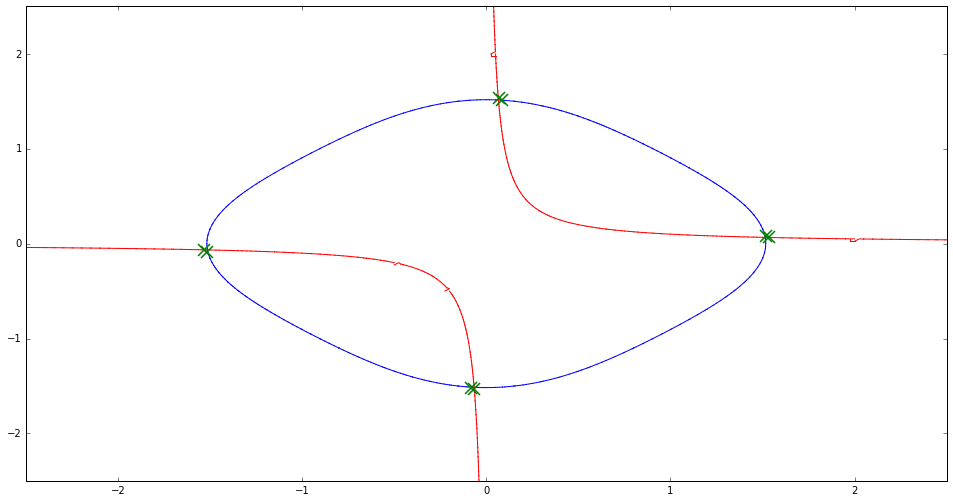

Candidatos a condições iniciais: 
[(-1.5166666666666664, -0.08333333333333298), (-1.5333333333333332, -0.0666666666666663), (-0.0666666666666663, -1.5333333333333332), (-0.08333333333333298, -1.5166666666666664), (0.08333333333333359, 1.5166666666666666), (0.06666666666666693, 1.5333333333333332), (1.5333333333333332, 0.06666666666666693), (1.5166666666666666, 0.08333333333333359)]


In [219]:
def F1(x):
    f1 = math.exp(-(x[0]**2+x[1]**2))*math.cos(x[0]*x[1]) - 0.1
    f2 = x[0]*x[1] - 0.1
    Fx = np.array([f1,f2])
    
    return Fx

def DF1(x):
    DFx = np.zeros((2,2))
    DFx[0][0] = (-2.0*x[0]*math.exp(-(x[0]**2+x[1]**2)))*math.cos(x[0]*x[1]) - \
                math.exp(-(x[0]**2+x[1]**2))*(math.sin(x[0]*x[1])*x[1])
    DFx[0][1] = (-2.0*x[1]*math.exp(-(x[0]**2+x[1]**2)))*math.cos(x[0]*x[1]) - \
                math.exp(-(x[0]**2+x[1]**2))*(math.sin(x[0]*x[1])*x[0])
    DFx[1][0] = x[1]
    DFx[1][1] = x[0]
    
    return DFx

l, k, tri_centers = twocurves(F1,0.0,-2.5,2.5,-2.5,2.5,100,100,20)
plot_curves(l, k, tri_centers, -2.5, 2.5, -2.5, 2.5, 100, 100)
print("Candidatos a condições iniciais: ")
print(tri_centers)

Na _Lista 3_ identificamos os centros dos triângulos que tem chance de conter o cruzamento das funções sob análise, para um dado nível. Acima pode-se visualizar tais pontos para o nível $z = 0$ e, devido a sua proximidade as raízes, é vantajoso utilizá-los como condições iniciais. Como para cada raiz encontrou-se mais de um centro de triângulo, selecionam-se manualmente alguns destes como candidatos iniciais e executa-se o _método de Newton_:

In [220]:
# Soluções de: http://www.wolframalpha.com/input/?i=Solve%5Bexp(-(x_0%5E2%2Bx_1%5E2))+*+cos(x_0+*+x_1)+-+0.1%3D0,+x_0*x_1+-+0.1%3D0%5D
eval_results(F1, DF1,\
             x_init_conds = [(-0.03333333333333297, -1.5666666666666664), (0.06666666666666667, 1.5333333333333332), \
                             (-1.533333333333333, -0.0666666666666663), (1.5333333333333332, 0.06666666666666667)], \
             x_sols_exp = [[-0.0660355, -1.51434], [0.0660355, 1.51434], \
                           [-1.51434, -0.0660355], [1.51434, 0.0660355]])

{1} Obtido: [-0.06603551 -1.51433683] vs Esperado: [-0.0660355, -1.51434] {Erro: 0.000003, Iterações: 3}
{2} Obtido: [ 0.06603551  1.51433683] vs Esperado: [0.0660355, 1.51434] {Erro: 0.000003, Iterações: 3}
{3} Obtido: [-1.51433683 -0.06603551] vs Esperado: [-1.51434, -0.0660355] {Erro: 0.000003, Iterações: 3}
{4} Obtido: [ 1.51433683  0.06603551] vs Esperado: [1.51434, 0.0660355] {Erro: 0.000003, Iterações: 3}


Como estas condições iniciais já são muito próximas as raízes, utiliza-se abaixo uma seleção de pontos um pouco mais distantes, para ver quantas iterações o algoritmo leva neste caso:

In [221]:
# Soluções de: http://www.wolframalpha.com/input/?i=Solve%5Bexp(-(x_0%5E2%2Bx_1%5E2))+*+cos(x_0+*+x_1)+-+0.1%3D0,+x_0*x_1+-+0.1%3D0%5D
eval_results(F1, DF1,\
             x_init_conds = [(-0.5, -1.8), (0.5, 1.8), \
                             (-1.8, -0.5), (1.8, 0.5)], \
             x_sols_exp = [[-0.0660355, -1.51434], [0.0660355, 1.51434], \
                           [-1.51434, -0.0660355], [1.51434, 0.0660355]])

{1} Obtido: [-0.06603551 -1.51433683] vs Esperado: [-0.0660355, -1.51434] {Erro: 0.000003, Iterações: 5}
{2} Obtido: [ 0.06603551  1.51433683] vs Esperado: [0.0660355, 1.51434] {Erro: 0.000003, Iterações: 5}
{3} Obtido: [-1.51433683 -0.06603551] vs Esperado: [-1.51434, -0.0660355] {Erro: 0.000003, Iterações: 5}
{4} Obtido: [ 1.51433683  0.06603551] vs Esperado: [1.51434, 0.0660355] {Erro: 0.000003, Iterações: 5}


Ainda convergiu bem rápido.

## Teste 2

Sejam $f_1$, $f_2$ e $F_2$:
$$
    f_1(x_0, x_1) = \log(x_0^2 + 2x_1^2 + 1) - 0.5 \\
    f_2(x_0, x_1) = x_1 + x_0^2 + 0.2 \\
    F_2(x_0, x_1) = \left ( \;f_1(x_0,x_1),\;f_2(x_0,x_1) \right )
$$
Seja $DF_2$ a _matriz Jacobiana_ de $F_2$:
$$
{DF}_2 =
\begin{vmatrix}
  \frac{2x_0}{\ln(x_0^2 + 2x_1^2 + 1)} & \frac{4x_1}{\ln(x_0^2 + 2x_1^2 + 1)} \\
  -2x_0 & 1.0  
\end{vmatrix}
$$

Deseja-se obter $\hat{x}$ que melhor aproxime a solução do sistema $F_2(\hat{x})= 0$, utilizando-se o _método de Newton_. Façamos o mesmo que no teste anterior, primeiramente aplicando o _método de Newton_ com as condições iniciais obtidas através dos métodos da _Lista 3_ e posteriormente condições iniciais piores, a fim de avaliar a convergência.

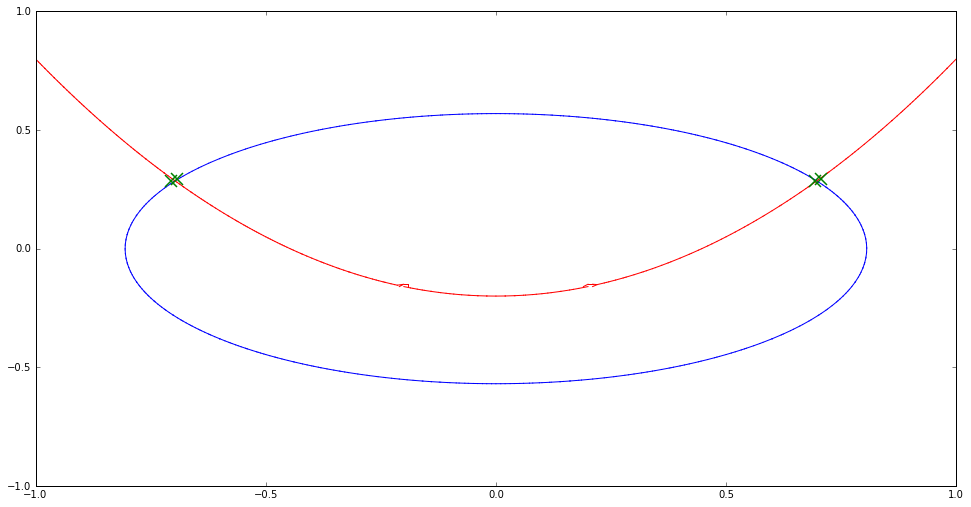

Candidatos a condições iniciais: 
[(-0.7066666666666667, 0.2866666666666667), (-0.6933333333333334, 0.2933333333333334), (0.6933333333333334, 0.2866666666666667), (0.7066666666666667, 0.2933333333333334)]
{1} Obtido: [ 0.69684555  0.28559372] vs Esperado: [0.7, 0.29] {Erro: 0.005419, Iterações: 40}
{2} Obtido: [-0.69684555  0.28559372] vs Esperado: [-0.7, 0.29] {Erro: 0.005419, Iterações: 36}


In [223]:
# Retiradas do slide 12-10 @ http://www.seas.ucla.edu/~vandenbe/103/lectures/newton.pdf
# Soluções esperadas: (0.70, 0.29), (-0.70, 0.29)
def F2(x):
    f1 = math.log(x[0]**2.0 + 2.0*x[1]**2.0 + 1.0) - 0.5
    f2 = x[1] - x[0]**2.0 + 0.2
    Fx = np.array([f1,f2])
    return Fx

def DF2(x):
    DFx = np.zeros((2,2), dtype=float)
    DFx[0][0] = 2.0*x[0]/(math.log(x[0]**2.0 + 2.0*x[1]**2.0 + 1.0))
    DFx[0][1] = 4.0*x[1]/(math.log(x[0]**2.0 + 2.0*x[1]**2.0 + 1.0))
    DFx[1][0] = -2.0*x[0]
    DFx[1][1] = 1.0
    
    return DFx

l, k, tri_centers = twocurves(F2,0.0,-1.0,1.0,-1.0,1.0,100,100,20)
plot_curves(l, k, tri_centers, -1.0, 1.0, -1.0, 1.0, 100, 100)
print("Candidatos a condições iniciais: ")
print(tri_centers)

eval_results(F2, DF2, \
             x_init_conds = [(0.6933333333333335, 0.2666666666666669), (-0.7066666666666667, 0.2666666666666669)], \
             x_sols_exp = [[0.70, 0.29], [-0.70, 0.29]])

In [224]:
eval_results(F2, DF2, \
             x_init_conds = [[1,1], [-1,1]], \
             x_sols_exp = [[0.70, 0.29], [-0.70, 0.29]])

{1} Obtido: [ 0.69684556  0.28559373] vs Esperado: [0.7, 0.29] {Erro: 0.005419, Iterações: 50}
{2} Obtido: [-0.69684556  0.28559373] vs Esperado: [-0.7, 0.29] {Erro: 0.005419, Iterações: 50}


Obtiveram-se resultados bem próximos aos esperados, sendo o erro de menos de $1\%$. Nota-se também que utilizando-se os centros dos triângulos a convergência acontece mais rapidamente, como esperado.